In [58]:
ls

AttentionGAN/            Gan_inference.ipynb  instancenormalization.py
cyborg_images_32x32.npz  gen_images_new2.png  __pycache__/
cyborg_images_64x64.npz  gen_images_new3.png  res/
CycleGAN/                gen_images_new.png   train_net_generator.ipynb
CycleGAN_Process.ipynb   Human_Cyborg_Data/   Untitled.ipynb
DCGAN/                   Human_photo/


In [59]:
from platform import python_version

print(python_version())

3.7.9


In [138]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from matplotlib import pyplot
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np

ImportError: cannot import name 'Adam' from 'keras.optimizers' (/opt/tljh/user/lib/python3.7/site-packages/keras/optimizers.py)

In [143]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint
import os
import numpy as np
from os import listdir
from matplotlib import pyplot as plt
from matplotlib import image
from PIL import Image

print(tf.__version__)

2.7.0


In [144]:
def load_images(path, size=(256,256)):
    data_list = list()
    for filename in listdir(path):
        if not filename.startswith('.ipynb'):
            pixels = load_img(path+filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
    return asarray(data_list)

Loaded dataA:  (35, 256, 256, 3)
Loaded dataB:  (35, 256, 256, 3)


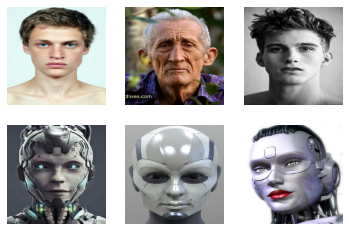

In [145]:
dataA_all = load_images('Human_photo/train/')
print('Loaded dataA: ', dataA.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=35,    
                 random_state=42) 

# load dataset B - Photos
# files_gambar = 'Human_Cyborg_Data/train/'
# file_jpg = [file for file in files_gambar if file[-4:] == ".jpg"]
dataB_all = load_images('Human_Cyborg_Data/train/')
print('Loaded dataB: ', dataB.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=35,    
                 random_state=42) 

# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

# load image data
data = [dataA, dataB]

In [146]:
# Prepare image data using tensorflow keras
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [116]:
image_shape = dataset[0].shape[1:]
image_shape

(256, 256, 3)

In [147]:
from instancenormalization import InstanceNormalization

In [82]:
trainA, trainB = dataset

In [83]:
print(len(trainA))
print(len(trainB))

39
39


In [102]:
def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [149]:
def define_generator(image_shape, n_resnet=9):
	# weight initializa|tion
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# Define Discriminator architecture

def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g


# Define Cycle GAN architecture

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time. 
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False
    
	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
    
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
    # define the optimizer
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
data = load('Human_photo')
x1 = data['arr_0']
x1

In [150]:
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1. 
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0. 
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores 
#the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)
 
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [152]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after 
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=100)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Iteration>1, dA[1.539,0.670] dB[1.066,0.842] g[18.003,20.974]
Iteration>2, dA[6.517,1.008] dB[6.804,1.211] g[20.891,20.533]
Iteration>3, dA[5.807,3.020] dB[3.519,0.884] g[17.315,21.955]
Iteration>4, dA[6.346,1.674] dB[4.116,1.102] g[20.580,20.191]
Iteration>5, dA[5.303,3.118] dB[5.738,1.566] g[16.975,16.823]
Iteration>6, dA[2.715,1.128] dB[1.502,1.130] g[17.107,18.050]
Iteration>7, dA[2.060,0.969] dB[2.381,1.107] g[16.833,17.338]
Iteration>8, dA[1.220,0.770] dB[0.806,1.766] g[18.131,16.531]
Iteration>9, dA[0.617,1.372] dB[1.599,4.916] g[13.452,14.567]
Iteration>10, dA[1.680,1.218] dB[0.786,1.523] g[15.543,16.370]
Iteration>11, dA[1.239,0.636] dB[1.073,1.999] g[13.825,11.379]
Iteration>12, dA[1.177,0.520] dB[1.390,0.829] g[11.268,11.119]
Iteration>13, dA[0.556,0.531] dB[1.974,0.818] g[12.246,10.396]
Iteration>14, dA[0.922,0.807] dB[0.836,0.617] g[10.006,9.594]
Iteration>15, dA[0.473,0.512] dB[0.655,1.120] g[9.427,7.972]
Iteration>16, dA[0.271,0.469] dB[0.500,0.866] g[9.595,8.380]
Iterat

In [93]:
image_shape = dataset[0].shape[1:]
image_shape

(256, 256, 3)

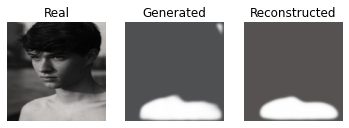

In [123]:
A_data = resample(dataA, 
                 replace=True,     
                 n_samples=10,    
                 random_state=42)
B_data = resample(dataB, 
                 replace=True,     
                 n_samples=10,    
                 random_state=42)
A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_001950.h5', cust, compile=False)
model_BtoA = load_model('g_model_BtoA_001950.h5', cust, compile=False)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB(A_real)
A_reconstructed = model_BtoA(B_generated)
show_plot(A_real, B_generated,A_reconstructed)